In [1]:
import pandas as pd
import json
import numpy as np
import os
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn import metrics
import time
import optuna
from optuna.samplers import RandomSampler
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import catboost as cb

rs = 42

# Gradient boosting

## XGBoost

In [2]:
obj = pd.read_csv('akb_obj_features_snad4.csv')
target = obj['label']
data = obj[obj.columns[2:]]

In [3]:
params = {'booster': 'dart',
 'lambda': 2.81750392241178e-07,
 'alpha': 3.403847848402039e-08,
 'subsample': 0.7928965194320472,
 'colsample_bytree': 0.6595784905439295,
 'max_depth': 9,
 'min_child_weight': 3,
 'eta': 0.023021758555949304,
 'gamma': 4.10221634196052e-07,
 'grow_policy': 'lossguide',
 'sample_type': 'uniform',
 'normalize_type': 'tree',
 'rate_drop': 0.10413682357387563,
 'skip_drop': 1.3789891825667776e-05}

print('Training model...')
t = time.monotonic()
model = xgb.XGBClassifier(**params, random_state=rs)
score_types = ('accuracy', 'roc_auc', 'f1')

result = cross_validate(model, data, target,
                        cv=KFold(shuffle=True, random_state=rs),
                        scoring=score_types,
                        return_estimator=True,
                        return_train_score=True,
                       )

print('Scores for XGBoost Classifier:')
for score in score_types:
    mean = np.mean(result[f'test_{score}'])
    std = np.std(result[f'test_{score}'])
    print(f'{score} = {mean:.2f} +- {std:.2f}')
t = (time.monotonic() - t) / 60
print(f'XGBoost trained (with cross-validation) in {t:.0f} m')

Training model...
Scores for XGBoost Classifier:
accuracy = 0.85 +- 0.02
roc_auc = 0.93 +- 0.01
f1 = 0.85 +- 0.01
XGBoost trained (with cross-validation) in 10 m


## CatBoost

In [3]:
params = {'objective': 'CrossEntropy',
 'colsample_bylevel': 0.06813255171984411,
 'depth': 7,
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bayesian',
 'bagging_temperature': 1.5285913918433203}

In [4]:
print('Training model...')
t = time.monotonic()
model = cb.CatBoostClassifier(**params, random_state=rs, verbose=0)
score_types = ('accuracy', 'roc_auc', 'f1')

result = cross_validate(model, data, target,
                        cv=KFold(shuffle=True, random_state=rs),
                        scoring=score_types,
                        return_estimator=True,
                        return_train_score=True,
                       )

print('Scores for CatBoost Classifier:')
for score in score_types:
    mean = np.mean(result[f'test_{score}'])
    std = np.std(result[f'test_{score}'])
    print(f'{score} = {mean:.2f} +- {std:.2f}')
t = (time.monotonic() - t) / 60
print(f'CatBoost trained (with cross-validation) in {t:.0f} m')

Training model...
Scores for CatBoost Classifier:
accuracy = 0.87 +- 0.02
roc_auc = 0.95 +- 0.01
f1 = 0.87 +- 0.02
CatBoost trained (with cross-validation) in 0 m


# Plot ROC curves

In [6]:
plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams["font.size"] = 22
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['lines.linewidth'] = 2.2

xtick_param = {'direction': 'in',
         'major.size': 8,
         'major.width': 2,
         'minor.size': 5,
         'minor.width': 1.5}
ytick_param = {'direction': 'in',
         'major.size': 8,
         'major.width': 2,
         'minor.size': 5,
         'minor.width': 1.5}
plt.rc('xtick', **xtick_param)
plt.rc('ytick', **ytick_param)

grid_param = {'linestyle': '--', 'alpha': 0.5}
plt.rc('grid', **grid_param)

In [3]:
obj = pd.read_csv('akb_obj_features_snad4.csv')
target = obj['label']
data = obj[obj.columns[2:]]

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=rs, shuffle=True)

def get_roc(model, X_train, X_test, y_train, y_test, name):
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    table = pd.DataFrame(dict(zip(['fpr', 'tpr'], [fpr, tpr])))
    table.to_csv(f'roc_curves_ac/{name}.csv', index=False)

In [4]:
params = {'booster': 'dart',
 'lambda': 2.81750392241178e-07,
 'alpha': 3.403847848402039e-08,
 'subsample': 0.7928965194320472,
 'colsample_bytree': 0.6595784905439295,
 'max_depth': 9,
 'min_child_weight': 3,
 'eta': 0.023021758555949304,
 'gamma': 4.10221634196052e-07,
 'grow_policy': 'lossguide',
 'sample_type': 'uniform',
 'normalize_type': 'tree',
 'rate_drop': 0.10413682357387563,
 'skip_drop': 1.3789891825667776e-05}

xgboost = xgb.XGBClassifier(**params, random_state=rs)
get_roc(xgboost, X_train, X_test, y_train, y_test, 'xgboost')

In [9]:
#params = {'objective': 'CrossEntropy',
# 'colsample_bylevel': 0.07976195410250031,
# 'depth': 12,
# 'boosting_type': 'Ordered',
# 'bootstrap_type': 'Bayesian',
# 'bagging_temperature': 0.45227288910538066}

params = {'objective': 'CrossEntropy',
 'colsample_bylevel': 0.06813255171984411,
 'depth': 7,
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bayesian',
 'bagging_temperature': 1.5285913918433203}

catboost = cb.CatBoostClassifier(**params, random_state=rs, verbose=0)
get_roc(catboost, X_train, X_test, y_train, y_test, 'catboost')

In [10]:
rf = RandomForestClassifier(max_depth=18, n_estimators=830, random_state=rs)
get_roc(rf, X_train, X_test, y_train, y_test, 'rf')

In [11]:
extratrees = ExtraTreesClassifier(max_depth=39, n_estimators=251, max_features=1, random_state=rs)
get_roc(extratrees, X_train, X_test, y_train, y_test, 'extratrees')

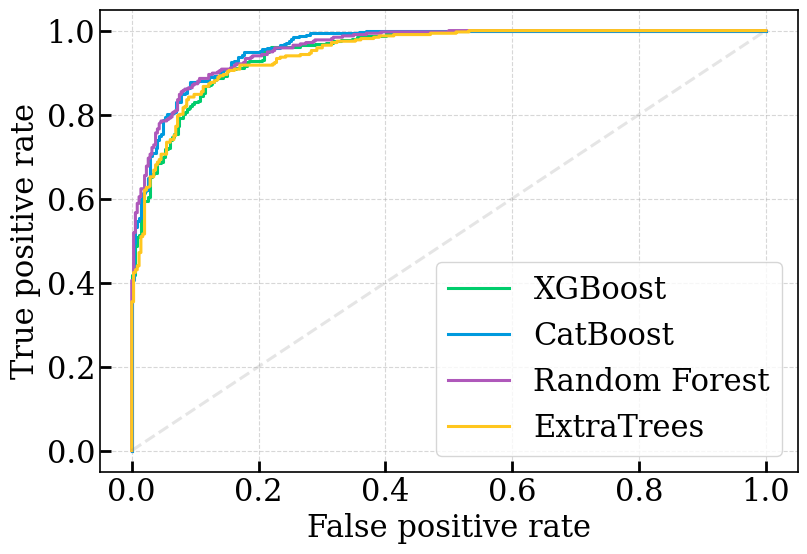

In [8]:
paths = [#'best_nn_roc.csv', 
        'xgboost.csv', 'catboost.csv', 'rf.csv', 'extratrees.csv']
names = [#'Neural network', 
        'XGBoost', 'CatBoost', 'Random Forest', 'ExtraTrees']
col = [#u'#FF1F5B', 
        u'#00CD6C', u'#009ADE', u'#AF58BA', u'#FFC61E']

lss = [ ':', '-.', '-', '--']

fig, ax = plt.subplots(figsize=(9, 6))
for i, name in enumerate(names):
    roc = pd.read_csv(f'roc_curves_ac/{paths[i]}')
    plt.plot(roc['fpr'], roc['tpr'], label=name, color=col[i])

plt.plot([0, 1], [0, 1], ls='--', alpha=0.2, c='gray')

#plt.title('ROC curve examples of trained models\nfor one of the cross-validation splits')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
ax.grid('on')
plt.legend()
plt.savefig('roc_curves_ac/roc_ac_bigfont.pdf', dpi=400, format='pdf', bbox_inches="tight")

# DAMDID

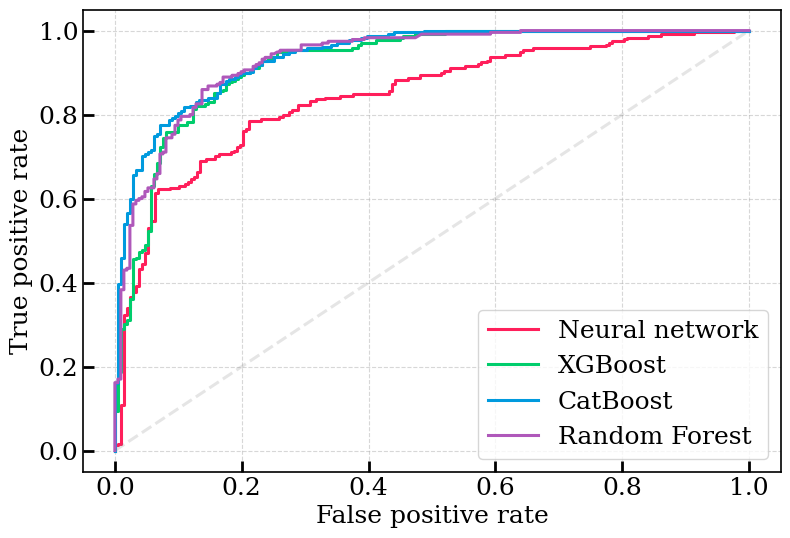

In [5]:
paths = ['best_nn_roc.csv', 
        'xgboost.csv', 'catboost.csv', 'rf.csv', 
         #'extratrees.csv'
        ]
names = ['Neural network', 
        'XGBoost', 'CatBoost', 'Random Forest', #'ExtraTrees'
        ]
col = [u'#FF1F5B', 
        u'#00CD6C', u'#009ADE', u'#AF58BA', #u'#FFC61E'
      ]

fig, ax = plt.subplots(figsize=(9, 6))
for i, name in enumerate(names):
    roc = pd.read_csv(f'roc_curves_damdid/{paths[i]}')
    plt.plot(roc['fpr'], roc['tpr'], label=name, color=col[i])

plt.plot([0, 1], [0, 1], ls='--', alpha=0.2, c='gray')

#plt.title('ROC curve examples of trained models\nfor one of the cross-validation splits')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
ax.grid('on')
plt.legend()
plt.savefig('roc_curves_damdid/roc.pdf', dpi=400, format='pdf', bbox_inches="tight")